In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.utils import multi_gpu_model

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True

set_session(tf.Session(config=config))
print tf.__version__

Using TensorFlow backend.


1.8.0


In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import keras
import re

print keras.__version__

2.1.6


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator

Start time: 1 pm

In [5]:
full_data_df = pd.read_hdf('../../data/full_data.hdf', 'full_data_df')

In [6]:
def process_raw_text(x, tokenize=True, filter_symbols=True):
    x = x.lower()
    x = x.replace(',', ' , ')
    x = x.replace('?', ' ? ')
    x = x.replace("'s ", " 's ")
    x = x.replace(". ", " . ")
    x = re.sub('\.{2,}', '', x)

    if filter_symbols:
        x = re.sub("[^a-z0-9\'\?\.]+", ' ', x)
    
    if tokenize:
        x = x.split(' ')
    
    return x


def jaccard_similarity(row):
    intersection = len(set(row['title_tokens']).intersection(row['caption_tokens']))
    union = len(set(row['title_tokens']).union(row['caption_tokens']))
    
    similarity = 1.0 * intersection / union
    
    return similarity


def get_effective_sample_text(row, sim_thresh=0.5):
    token_set = []
    title_tokens = row['title_tokens']
    caption_tokens = row['caption_tokens']
    
    if row['jaccard_sim'] > sim_thresh:
        if len(title_tokens) > len(caption_tokens):
            token_set.extend(title_tokens)
        else:
            token_set.extend(caption_tokens)
    else:
        token_set.extend(title_tokens)
        token_set.extend(caption_tokens)
        
    return token_set


def get_embedding_index(pre_trained_file, word_index):
    # Expected format is space separated.
    # First item is the word and succedding items are the elements of the vector
    embedding_index = {}
    
    with open(pre_trained_file) as fl:
        for line in fl:
            line = line.strip().split()
            word = line[0]
            vector = line[1:]
            if word in word_index:
                embedding_index[word] = np.array(vector, dtype=np.float32)
                
    return embedding_index

## Text data processing

In [7]:
sample_data = full_data_df[full_data_df.columns.drop(['image_link', 'image_type', 'record_id'])].loc[full_data_df.index]

sample_data['title_tokens'] = sample_data['title'].map(process_raw_text)
sample_data['caption_tokens'] = sample_data['caption'].map(process_raw_text)

sample_data['jaccard_sim'] = sample_data.apply(jaccard_similarity, axis=1)
sample_data['tokens'] = sample_data.apply(get_effective_sample_text, axis=1)

sample_data = sample_data.drop(['caption', 'title', 'title_tokens', 'caption_tokens', 'jaccard_sim'], axis=1)

In [8]:
tokenizer = Tokenizer(num_words=None, filters='', lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(sample_data['tokens'].map(lambda x: ' '.join(x)))

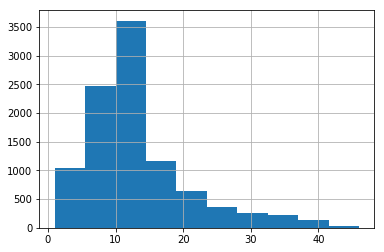

In [9]:
pd.Series([len(i) for i in tokenizer.texts_to_sequences(
    sample_data['tokens'].map(lambda x: ' '.join(x))
)]).hist()

In [10]:
EMBEDDING_DIM = 300
MAXLEN = 30

# tokenizer.num_words = 

In [11]:
sample_data['sequence'] = pad_sequences(
    tokenizer.texts_to_sequences(
        sample_data['tokens'].map(lambda x: ' '.join(x))
    ), maxlen=MAXLEN, padding='post', truncating='post'
).tolist()

In [12]:
%%time
embeddings_index = get_embedding_index(
    pre_trained_file='/mnt/Datastore/WORK/pre-trained-models/glove.840B.300d.txt',
    word_index=tokenizer.word_index
)

CPU times: user 23.9 s, sys: 650 ms, total: 24.5 s
Wall time: 24.5 s


In [13]:
%%time
# Keras reserves index 0 for masking
word_index = tokenizer.word_index

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 13632 word vectors.
CPU times: user 29.6 ms, sys: 12.1 ms, total: 41.8 ms
Wall time: 41.2 ms


## Image data processing

In [14]:
# # np.stack(sample_data.head(32)['image'].map(load_image))

# image_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# # Exploit image_datagen for dynamic perturbation of the data
# image_data = image_datagen.flow(
#     np.stack(sample_data.head(32)['image'].map(load_image)),
# #     np.stack(positive_df['image'].map(load_image)),
#     batch_size=32, shuffle=False
# ).next()

In [15]:
image_cache = {}

In [16]:
image_size = (256, 256, 3)

In [25]:
from keras.applications import VGG16
 
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=image_size)

In [26]:
def recast_array_to_image(float_array):
    uint_array = (float_array * 255 / np.max(float_array)).astype('uint8')

    return Image.fromarray(uint_array)


def load_image(path, size=image_size[:-1]):
    if path not in image_cache:

        im = Image.open(path)
        im = im.resize(size)

        im = np.asarray(im, dtype=np.float32)

        if im.ndim == 2:
            im = np.stack([im] * 3, axis=2)
            
        image_cache[path] = im
        
    return image_cache[path]


def dataset_generator(dataset, batch_size=32, shuffle=True, negative_fold=1):
    index = dataset.index.values

    image_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    full_batch_size = batch_size * (negative_fold + 1)

    batch_index = []
    while True:
        if shuffle:
            np.random.shuffle(index)
        
        for i in index:
            if len(batch_index) < batch_size:
                batch_index.append(i)

            else:
                negative_index = np.random.choice(index, size=batch_size * negative_fold, replace=True)
                positive_df = dataset.loc[batch_index]

                image_data = positive_df['image'].map(load_image)
                image_data = np.stack(image_data)

                # Exploit image_datagen for dynamic perturbation of the data
                image_data = image_datagen.flow(
                    image_data,
                    batch_size=batch_size, shuffle=False
                ).next()
                image_data = np.vstack([image_data] * (negative_fold + 1))
                
                positive_text_data = np.stack(positive_df['sequence'])
                negative_text_data = np.stack(dataset.loc[negative_index]['sequence'])
                
                text_data = np.vstack([positive_text_data, negative_text_data])
                
                label = np.zeros(full_batch_size)
                label[:batch_size] = 1
                
                ix = np.array(range(full_batch_size))
                if shuffle:
                    ix = np.random.choice(ix, size=full_batch_size, replace=False)
                
                batch_index = []
                yield [text_data[ix], conv_base.predict(image_data[ix])], label[ix]

In [39]:
data_gen = dataset_generator(sample_data, batch_size=32, shuffle=True, negative_fold=3)

In [30]:
%%time
q = data_gen.next()

CPU times: user 1.78 s, sys: 682 ms, total: 2.46 s
Wall time: 2.45 s


In [29]:
from keras.layers import Input, GRU, Bidirectional, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout

In [74]:
sample_data.head()

,image,tokens,sequence
5605,../../data/img/cat/UynY573QfTtKJM:.jpeg,"[what, is, a, cat, flehmen, response, ?, catst...","[44, 18, 5, 19, 7840, 2813, 26, 1241, 5, 19, 4..."
2022,../../data/img/cat/R_RzGB4kWjBx-M:.jpeg,"[this, cat, is, taking, over, the, internet, w...","[46, 19, 18, 602, 261, 1, 603, 22, 325, 2442, ..."
3037,../../data/img/cat/hMjxy8pUhhc4QM:.jpeg,"[cat, wiktionary, ]","[19, 2816, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6498,../../data/img/cat/95ZyfykCV3X6nM:.jpeg,"[caring, for, cats, in, cold, weather, argos, ...","[1439, 9, 47, 4, 1579, 1009, 2817, 110, 376, 1..."
8212,../../data/img/cat/Vx5sPhwu_EDaTM:.jpeg,"[cat, and, kitten, flea, treatment, advice, ho...","[19, 3, 326, 3339, 1903, 727, 35, 6, 125, 4095..."


In [76]:
sample_data.iloc[[5605, 2022]]

,image,tokens,sequence
8783,../../data/img/panda/2eiqlFHfk4KwIM:.jpeg,"[threats, wwf, ]","[2653, 411, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4830,../../data/img/python/7vBohn-kfQ6F3M:.png,"[let, 's, synchronize, threads, in, python, ha...","[1032, 12, 9498, 9499, 4, 16, 1821, 2030, 921,..."


In [40]:
text_model_input = keras.layers.Input(shape=(MAXLEN,))
text_embedding = keras.layers.Embedding(
    input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False
)(text_model_input)

text_gru = Bidirectional(GRU(64, return_sequences=True))(text_embedding)
text_gru = Bidirectional(GRU(64))(text_gru)
text_dense = Dense(300, activation='relu')(text_gru)
text_dense = Dropout(0.3)(text_dense)
text_model_output = Dense(100, activation='tanh')(text_dense)

image_model_input = Input(shape=(8, 8, 512))
# image_model_shaped = keras.layers.Reshape((64, 64, 2), input_shape=(4, 4, 512))(image_model_input)

image_conv = Conv2D(128, 2)(image_model_input)
# image_conv = Conv2D(64, 2)(image_conv)
image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

# image_conv = Conv2D(32, 2)(image_pool)

# image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
image_flatten = Flatten()(image_pool)
image_dense = Dense(300, activation='relu')(image_flatten)
image_dense = Dropout(0.3)(image_dense)
image_model_output = Dense(100, activation='tanh')(image_flatten)

target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

ImageSearchModel.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy'
)

In [41]:
q = data_gen.next()

In [42]:
ImageModel = keras.models.Model(inputs=[image_model_input], outputs=[image_model_output])
TextModel = keras.models.Model(inputs=[text_model_input], outputs=[text_model_output])

In [43]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=1)

Epoch 1/1
311/311 [==============================] - 313s 1s/step - loss: 0.5336
CPU times: user 4min 45s, sys: 1min 10s, total: 5min 56s
Wall time: 5min 15s


In [44]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=10)

Epoch 1/10
311/311 [==============================] - 311s 1s/step - loss: 0.4405
Epoch 2/10
311/311 [==============================] - 312s 1s/step - loss: 0.3840
Epoch 3/10
311/311 [==============================] - 312s 1s/step - loss: 0.3498
Epoch 4/10
311/311 [==============================] - 313s 1s/step - loss: 0.3401
Epoch 5/10
311/311 [==============================] - 313s 1s/step - loss: 0.3326
Epoch 6/10
311/311 [==============================] - 312s 1s/step - loss: 0.3188
Epoch 7/10
311/311 [==============================] - 312s 1s/step - loss: 0.3113
Epoch 8/10
311/311 [==============================] - 312s 1s/step - loss: 0.3016
Epoch 9/10
311/311 [==============================] - 312s 1s/step - loss: 0.2964
Epoch 10/10
311/311 [==============================] - 312s 1s/step - loss: 0.2951
CPU times: user 47min 6s, sys: 11min 34s, total: 58min 41s
Wall time: 52min 2s


In [45]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=10)

Epoch 1/10
311/311 [==============================] - 312s 1s/step - loss: 0.2856
Epoch 2/10
311/311 [==============================] - 312s 1s/step - loss: 0.2792
Epoch 3/10
311/311 [==============================] - 313s 1s/step - loss: 0.2758
Epoch 4/10
311/311 [==============================] - 313s 1s/step - loss: 0.2690
Epoch 5/10
311/311 [==============================] - 312s 1s/step - loss: 0.2665
Epoch 6/10
311/311 [==============================] - 313s 1s/step - loss: 0.2648
Epoch 7/10
311/311 [==============================] - 313s 1s/step - loss: 0.2603
Epoch 8/10
311/311 [==============================] - 314s 1s/step - loss: 0.2557
Epoch 9/10
311/311 [==============================] - 313s 1s/step - loss: 0.2569
Epoch 10/10
311/311 [==============================] - 313s 1s/step - loss: 0.2525
CPU times: user 47min 7s, sys: 11min 39s, total: 58min 46s
Wall time: 52min 8s


In [102]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=10)

Epoch 1/10
311/311 [==============================] - 313s 1s/step - loss: 0.2438
Epoch 2/10
311/311 [==============================] - 311s 999ms/step - loss: 0.2414
Epoch 3/10
311/311 [==============================] - 311s 1s/step - loss: 0.2381
Epoch 4/10
311/311 [==============================] - 312s 1s/step - loss: 0.2397
Epoch 5/10
311/311 [==============================] - 311s 1s/step - loss: 0.2345
Epoch 6/10
311/311 [==============================] - 312s 1s/step - loss: 0.2295
Epoch 7/10
311/311 [==============================] - 312s 1s/step - loss: 0.2305
Epoch 8/10
311/311 [==============================] - 312s 1s/step - loss: 0.2265
Epoch 9/10
311/311 [==============================] - 312s 1s/step - loss: 0.2237
Epoch 10/10
311/311 [==============================] - 312s 1s/step - loss: 0.2251
CPU times: user 47min 10s, sys: 11min 32s, total: 58min 43s
Wall time: 51min 59s


In [103]:
ImageSearchModel.save('ImageSearchModel-30epochs.hd5')

In [104]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=50)

Epoch 1/50
311/311 [==============================] - 317s 1s/step - loss: 0.2235
Epoch 2/50
311/311 [==============================] - 318s 1s/step - loss: 0.2185
Epoch 3/50
311/311 [==============================] - 317s 1s/step - loss: 0.2156
Epoch 4/50
311/311 [==============================] - 317s 1s/step - loss: 0.2116
Epoch 5/50
311/311 [==============================] - 318s 1s/step - loss: 0.2127
Epoch 6/50
311/311 [==============================] - 318s 1s/step - loss: 0.2161
Epoch 7/50
311/311 [==============================] - 317s 1s/step - loss: 0.2063
Epoch 8/50
311/311 [==============================] - 317s 1s/step - loss: 0.2121
Epoch 9/50
311/311 [==============================] - 318s 1s/step - loss: 0.2042
Epoch 10/50
311/311 [==============================] - 318s 1s/step - loss: 0.2032
Epoch 11/50
311/311 [==============================] - 318s 1s/step - loss: 0.2083
Epoch 12/50
311/311 [==============================] - 318s 1s/step - loss: 0.2008
Epoch 13/50
3

In [105]:
ImageSearchModel.save('ImageSearchModel-80epochs.hd5')

In [106]:
%%time
predict_image_datagen = ImageDataGenerator(
    rescale=1./255,
)

image_data = sample_data['image'].map(load_image)
image_data = np.stack(image_data)

# Exploit image_datagen for dynamic perturbation of the data
image_data = predict_image_datagen.flow(
    image_data,
    batch_size=sample_data.shape[0], shuffle=False
).next()

CPU times: user 1.98 s, sys: 5.65 s, total: 7.63 s
Wall time: 8.46 s


In [107]:
%%time
image_embeddings = ImageModel.predict(conv_base.predict(image_data))

CPU times: user 41.8 s, sys: 14.9 s, total: 56.7 s
Wall time: 55 s


In [108]:
image_embeddings.shape

(9957, 100)

In [109]:
from sklearn.metrics.pairwise import cosine_similarity

In [237]:
query_vector = TextModel.predict(
    pad_sequences(
        tokenizer.texts_to_sequences(
            [' '.join(process_raw_text('lamborghini lamborghini'))]
        ), maxlen=MAXLEN, padding='post', truncating='post'
    )
)

In [238]:
pad_sequences(
    tokenizer.texts_to_sequences(
        [' '.join(process_raw_text('lamborghini'))]
    ), maxlen=MAXLEN, padding='post', truncating='post'
)

array([[958,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

In [239]:
%%time
res = cosine_similarity(image_embeddings, query_vector)

CPU times: user 12.6 ms, sys: 37.2 ms, total: 49.8 ms
Wall time: 9.1 ms


In [240]:
top_ix = res[:, 0].argsort()[::-1][:10]
print(res[:, 0][top_ix])
print(top_ix)

[0.904109  0.9041075 0.9040807 0.8946484 0.8944086 0.8943785 0.894312
 0.8841709 0.8841709 0.884093 ]
[3960 3745 4071 3767 3647 4099 3990 3804 3943 3904]


In [241]:
sample_data.iloc[top_ix]

,image,tokens,sequence
1623,../../data/img/car/kGAyr0qr7nEHFM:.jpeg,"[getaround, peer, to, peer, car, sharing, and,...","[11310, 3846, 6, 3846, 29, 1400, 3, 951, 29, 4..."
3647,../../data/img/car/aQ_09_u1-O-foM:.jpeg,"[www.cstatic, images.com, stock, 379x253, 63, ...","[3141, 3142, 89, 6598, 3820, 11162, 0, 0, 0, 0..."
17,../../data/img/car/viigArJelrk7zM:.jpeg,"[cars, insider, cars, insider, updated, their,...","[55, 551, 55, 551, 955, 131, 406, 63, 13, 127,..."
7339,../../data/img/car/qE_PqrCu8lMkGM:.jpeg,"[get, the, best, price, save, on, your, next, ...","[125, 1, 38, 151, 577, 20, 33, 417, 29, 5917, ..."
8926,../../data/img/car/yA9yLp2u0qj0JM:.jpeg,"[mclaren, senna, reviews, mclaren, senna, pric...","[1870, 3809, 166, 1870, 3809, 151, 87, 3, 395,..."
4630,../../data/img/car/DT3-l83AqkKVKM:.jpeg,"[2016, chevrolet, camaro, overview, cars.com, ]","[299, 2080, 2086, 991, 2362, 0, 0, 0, 0, 0, 0,..."
7424,../../data/img/car/j4O_PexChflYBM:.jpeg,"[numerous, benefits, of, purchasing, used, car, ]","[6686, 1605, 2, 11341, 190, 29, 0, 0, 0, 0, 0,..."
8102,../../data/img/car/Yirk0T1bWpDgMM:.jpeg,"[car, malaysia, latest, news, reviews, on, aut...","[29, 798, 317, 91, 166, 20, 6627, 6628, 6629, ..."
3588,../../data/img/car/Yirk0T1bWpDgMM:.jpeg,"[car, malaysia, latest, news, reviews, on, aut...","[29, 798, 317, 91, 166, 20, 6627, 6628, 6629, ..."
7671,../../data/img/car/vtHGOLJS44ooMM:.jpeg,"[uber, self, driving, car, kills, arizona, ped...","[4608, 613, 715, 29, 2926, 2918, 11264, 11265,..."


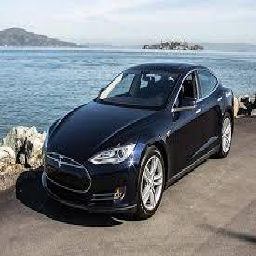

In [242]:
Image.fromarray(
    load_image(
        sample_data.iloc[3960]['image']
#         '../../data/img/physics/jT6AxO5im1R5zM:.jpeg'
    ).astype(np.uint8)
)

In [60]:
sample_data.loc[6159]

image                 ../../data/img/sea/92xZrnaPVNyNkM:.jpeg
tokens      [sea, turtles, of, st, ., george, island, reso...
sequence    [21, 1665, 2, 1502, 13, 3668, 1117, 709, 3227,...
Name: 9828, dtype: object

In [42]:
record = sample_data.loc[3]

In [43]:
print record['caption'].lower()
print record['title'].lower()

caring for cats in cold weather - grey and white cat close up
caring for cats in cold weather - argos pet insurance


In [ ]:
str.index